In [124]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 17.0
plt.rc('text', usetex=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Temporal study of network parameters

In [86]:
def parse_time(team, matchid):
    df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
    df = df[df['MatchID'] == matchid]
    df = df[df['TeamID'] == team]
    
    df_full = pd.read_csv('./2020_Problem_D_DATA/fullevents.csv')
    df_full = df_full[df_full['MatchID'] == matchid]
    df_full = df_full[df_full['TeamID'] == team]
    first_half_time = df_full[df_full['MatchPeriod'] == '1H'].iloc[-1]['EventTime']
    
    df.loc[df['MatchPeriod'] == '2H', 'EventTime'] += first_half_time
    return df

In [94]:
def temporal_network_params(team, matchid, length=50):
    from network import build_network, plot_network, calc_network_params
    df = parse_time(team, matchid)
    
    df = df[df['TeamID'] == team]
    df = df[df['MatchID'] == matchid]
    time = df['EventTime'].values
    
    net_param_dict = {}
    for i in range(len(df)):
        if length + i >= len(df):
            break
        if i % 20 == 0:
            print(i)
        G, pos, centrality_dict, geometrical_dist, unidirection_pass, weight_dict = build_network(
            df[i:length + i], team, matchid)
        network_params = calc_network_params(G)
        local_time = time[length + i] - time[i]
        network_params['delta_time'] = local_time
        network_params['time'] = time[length + i]
        net_param_dict[i] = network_params
        
    df_net_param = pd.DataFrame(net_param_dict).T
    return df_net_param

In [181]:
df_net_huskies = temporal_network_params('Huskies', 18)

0
20
40
60
80
100
120
140
160
180
200
220
240
260


In [182]:
df_net_opponent = temporal_network_params('Opponent18', 18)

0
20
40
60
80
100
120
140
160
180
200
220
240


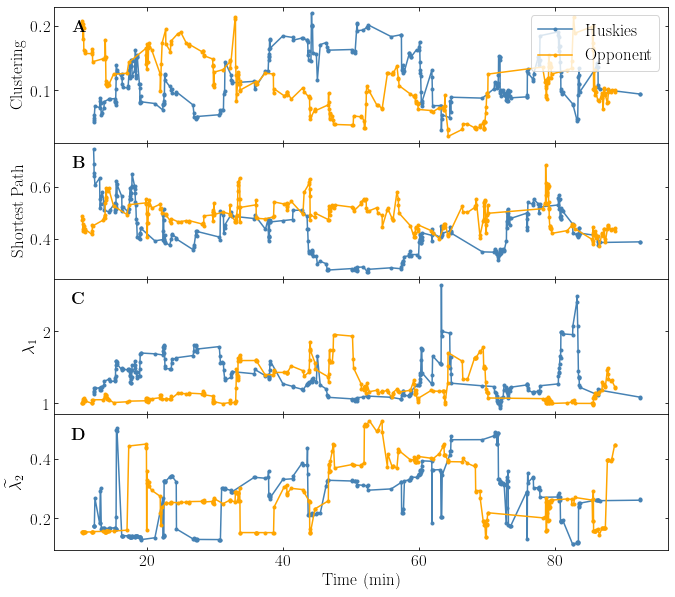

In [193]:
plt.rc('text', usetex=True)

fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)

keywords = [
    'clustering_coeff', 'shortest_path', 'largest_eigenvalue', 'algebraic_conn'
]

ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$']

tag_set = ['A', 'B', 'C', 'D', 'E', 'F']

for ind, key in enumerate(keywords):
    ax = axes[ind]
    ax.plot(df_net_huskies['time'].values / 60, df_net_huskies[key].values, 
            color='steelblue', marker='.', label='Huskies')
    ax.plot(df_net_opponent['time'].values / 60, df_net_opponent[key].values, 
            color='orange', marker='.', label='Opponent')

    ax.set_ylabel(ylabel_set[ind])
    ax.set_xlabel('Time (min)')
    
    ax.tick_params(direction='in', left=True, right=True, 
                    bottom=True, top=True, labelleft=True, labelbottom=False)
    if ind == 0:
        ax.legend(loc='upper right')
    ylim = ax.get_ylim()
    ax.text(10, ylim[1] - (ylim[1] - ylim[0]) * 0.15, 
            r'$\textbf{' + tag_set[ind] + '}$', 
            fontsize=17,
            fontweight='bold',
            horizontalalignment='center', 
            verticalalignment='center')
    
axes[3].tick_params(direction='in', left=True, right=True, 
                    bottom=True, top=True, labelleft=True, labelbottom=True)
    
plt.subplots_adjust(hspace=0)

#plt.savefig('./Draft/temporal-net-params-m18.pdf', dpi=200, bbox_inches='tight')
#plt.savefig('./Draft/temporal-net-params-m18.png', dpi=200, bbox_inches='tight')

## Temporal Classical Metrics

In [135]:
def cal_mean_position(df_pass, direction):
    huskies_coor_mean = df_pass['EventOrigin_{}'.format(direction)].mean()
    return huskies_coor_mean

def cal_centroid_disp(df_pass):
    x_cen = cal_mean_position(df_pass, 'x')
    y_cen = cal_mean_position(df_pass, 'y')
    
    dist = np.sqrt(np.square(df_pass['EventOrigin_x'] - x_cen) + \
                   np.square(df_pass['EventOrigin_y'] - y_cen))
    
    dispersion = np.std(dist, ddof=1)
    return dispersion

def cal_advance(df_pass):
    delta_x = np.abs(df_pass['EventDestination_x'] - df_pass['EventOrigin_x'])
    delta_y = np.abs(df_pass['EventDestination_y'] - df_pass['EventOrigin_y'])
    
    return delta_y.sum() / delta_x.sum()

In [166]:
def temporal_classical_metrics(team, matchid, length=50):
    from network import build_network, plot_network, calc_network_params
    df = parse_time(team, matchid)
    
    df = df[df['TeamID'] == team]
    df = df[df['MatchID'] == matchid]
    time = df['EventTime'].values
    
    metrics_dict = {}
    for i in range(len(df)):
        if length + i >= len(df):
            break
        metric_params = {}
        metric_params['x_cen'] = cal_mean_position(df[i:length + i], 'x')
        metric_params['y_cen'] = cal_mean_position(df[i:length + i], 'y')
        metric_params['cen_disp'] = cal_centroid_disp(df[i:length + i])
        metric_params['advance'] = cal_advance(df[i:length + i])
        
        local_time = time[length + i] - time[i]
        metric_params['delta_time'] = local_time
        metric_params['time'] = time[length + i]
        
        metrics_dict[i] = metric_params
        
    df_metrics = pd.DataFrame(metrics_dict).T
    return df_metrics

In [179]:
df_metrics_huskies = temporal_classical_metrics('Huskies', 18)
df_metrics_opponent = temporal_classical_metrics('Opponent18', 18)

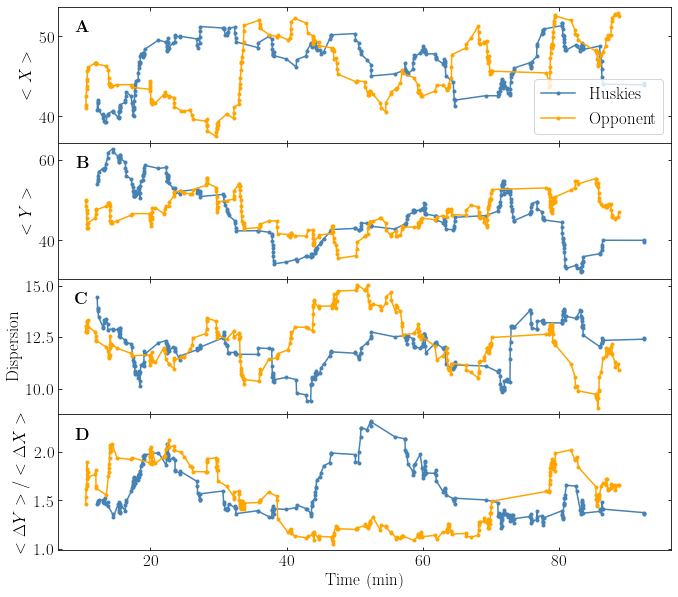

In [191]:
plt.rc('text', usetex=True)

fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)

keywords = [
    'x_cen', 'y_cen', 'cen_disp', 'advance'
]

ylabel_set = [r'$<X>$', r'$<Y>$', 
              'Dispersion', r'$<\Delta Y>/<\Delta X>$']

tag_set = ['A', 'B', 'C', 'D', 'E', 'F']

for ind, key in enumerate(keywords):
    ax = axes[ind]
    ax.plot(df_metrics_huskies['time'].values / 60, df_metrics_huskies[key].values, 
            color='steelblue', marker='.', label='Huskies')
    ax.plot(df_metrics_opponent['time'].values / 60, df_metrics_opponent[key].values, 
            color='orange', marker='.', label='Opponent')

    ax.set_ylabel(ylabel_set[ind])
    ax.set_xlabel('Time (min)')
    
    ax.tick_params(direction='in', left=True, right=True, 
                    bottom=True, top=True, labelleft=True, labelbottom=False)
    if ind == 0:
        ax.legend()
    ylim = ax.get_ylim()
    ax.text(10, ylim[1] - (ylim[1] - ylim[0]) * 0.15, 
            r'$\textbf{' + tag_set[ind] + '}$', 
            fontsize=17,
            fontweight='bold',
            horizontalalignment='center', 
            verticalalignment='center')
    
    
axes[3].tick_params(direction='in', left=True, right=True, 
                    bottom=True, top=True, labelleft=True, labelbottom=True)
    
plt.subplots_adjust(hspace=0)


plt.savefig('./Draft/temporal-spatial-m18.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/temporal-spatial-m18.png', dpi=200, bbox_inches='tight')